In [1]:
# all the imports used throughout the notebook:
import json
import pandas as pd
import numpy as np
import wrangle
import acquire
import model
from prepare import basic_clean, tokenize, lemmatize, stem, remove_stopwords, prep_string_data#, split_data
import scipy as sp
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import nltk

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
eval_df, train, validate, test = model.run_modeling()

The df has 1889857 rows and 12 columns.
train shape is (56000, 13)
validate shape is (24000, 13)
test shape is (20000, 13)
Basic Splits Created
TF_IDF Splits Created
Count Vectorizer Splits Created
Logistic Regression Beginning
LR done
Decision Tree beginning
DT done
Random Forest beginning
RF done


In [3]:
eval_df

,Model_Type,Train_Accuracy,Validate_Accuracy,Accuracy_Difference,Beats_Baseline_By
0,baseline_pred,0.621768,0.621792,-0.000024,-0.002851
0,Log_Reg_Just_Features,0.673982,0.676625,-0.002643,0.051982
0,Log_Reg_Just_TFIDF,0.816875,0.775208,0.041667,0.150565
0,Log_Reg_TFIDF_Plus_Features,0.756875,0.757292,-0.000417,0.132649
0,Log_Reg_CV,0.849893,0.756042,0.093851,0.131399
0,Log_Reg_CV_Plus_Features,0.774732,0.768333,0.006399,0.143690
0,Decision_Tree_Just_Features,0.725000,0.721375,0.003625,0.096732
0,DecisionTree_Just_TFIDF,0.688089,0.686833,0.001256,0.062190
0,Decision_Tree_TFIDF_PlusFeatures,0.738089,0.739292,-0.001202,0.114649
0,DecisionTree_Just_Countvectorizer,0.688125,0.686667,0.001458,0.062024


## REDEFINE BASELINE IN .PY

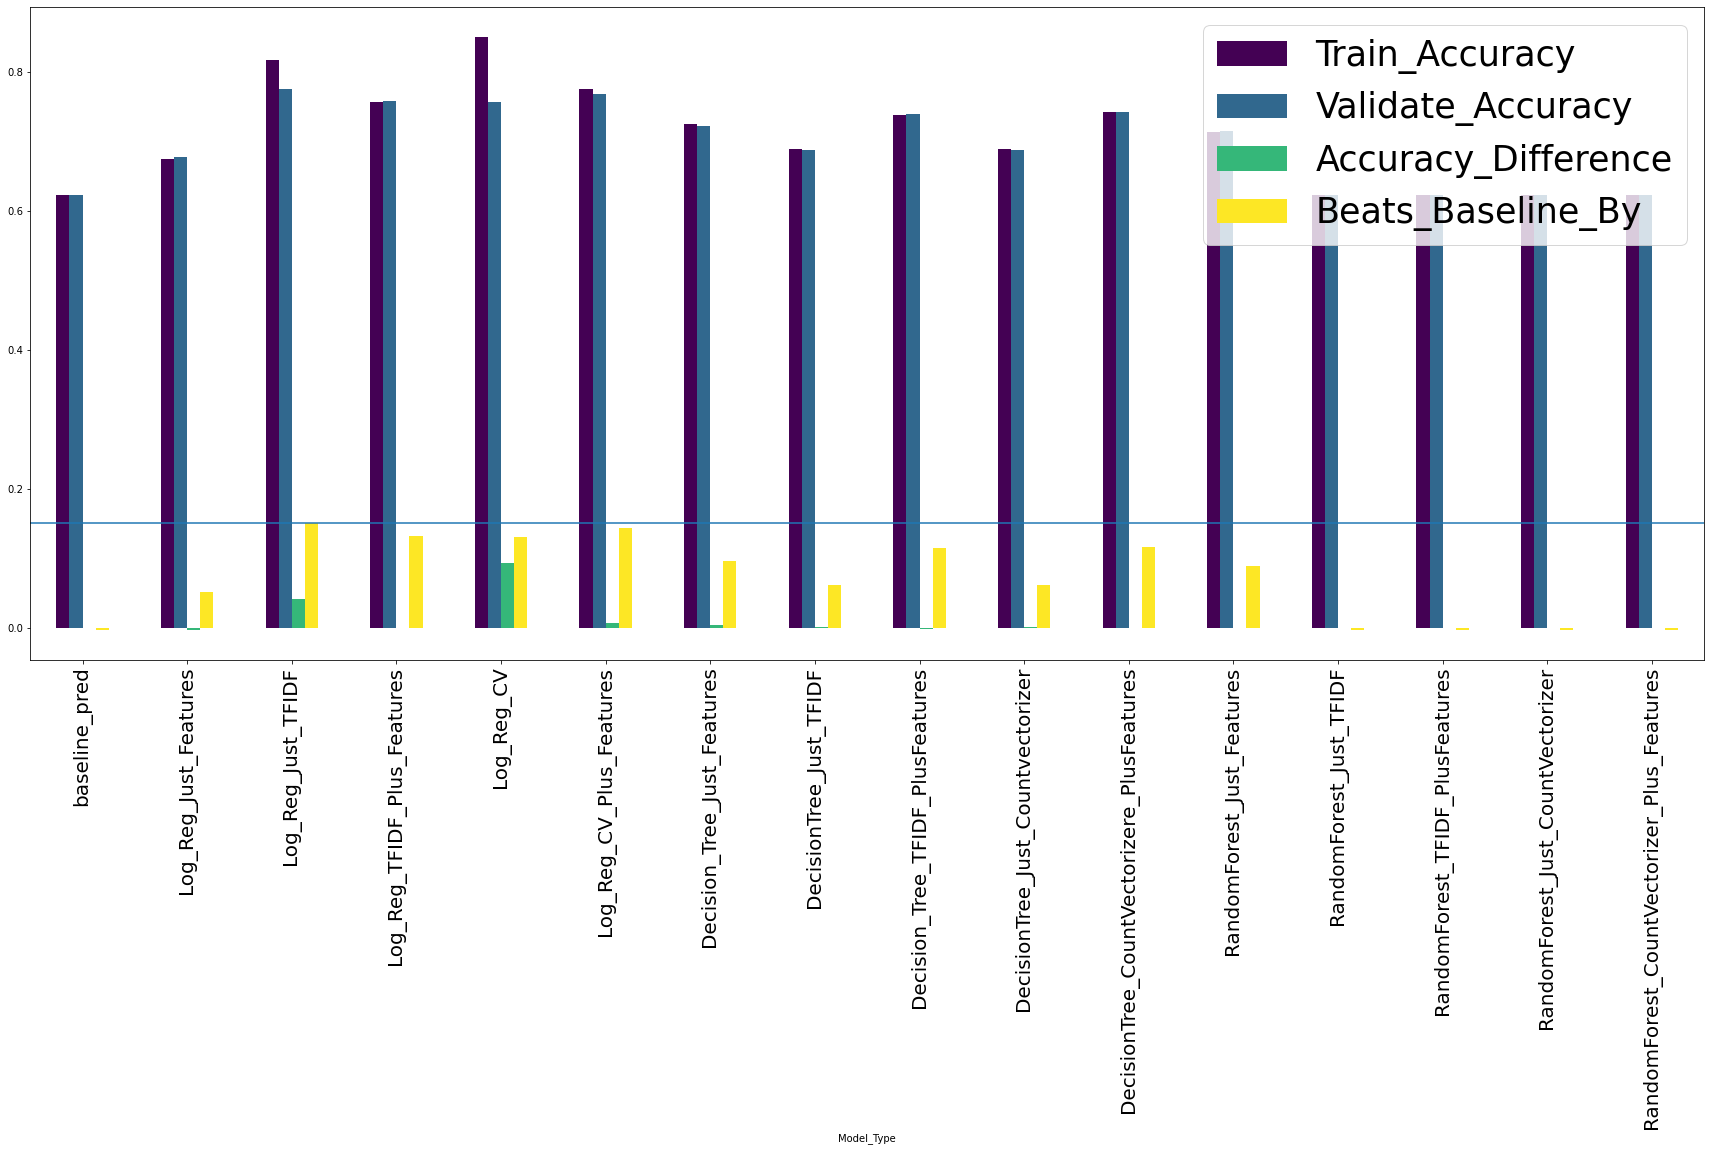

In [4]:
from matplotlib import cm
# define columns of eval df for use plotting below
columns = ['Train_Accuracy', 'Validate_Accuracy','Accuracy_Difference', 'Beats_Baseline_By']
cmap = cm.get_cmap('viridis')
# plot all the results, grouped by model
eval_df.plot(x='Model_Type', y=columns, kind="bar", figsize=(30,12),cmap=cmap)

plt.legend(prop={'size': 35}, loc='upper right')#(loc=(1.01,1.2), bbox_to_anchor=(.5, 0., .5, .5))
# ax.xaxis.set_tick_params(labelsize=20)
# ax.yaxis.set_tick_params(labelsize=20)

# add h line for highest gross performing model
plt.axhline(y=eval_df.Beats_Baseline_By.max())
plt.xticks(rotation=90, fontsize=20);

## The best model in our opionion is the Logistic Regression on Count Vectorizer plus additional Features

## Running this model on TEST

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()

In [6]:
print('Train Accuracy, Countvectorizer_PlusFeatures: {:.2%}'.format(accuracy_score(train.actual, train.predicted_X_cv_plus_features)))
print('---')
# print('Confusion Matrix')
# print(pd.crosstab(train.predicted, train.actual))
# print('---')
print('Validate Accuracy, Countvectorizer_PlusFeatures: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_X_cv_plus_features)))
print('---')

print('Test Accuracy, Countvectorizer_PlusFeatures: {:.2%}'.format(accuracy_score(test.actual, test.predicted_X_cv_plus_features)))
print(classification_report(test.actual, test.predicted_X_cv_plus_features))


Train Accuracy, Countvectorizer_PlusFeatures: 77.47%
---
Validate Accuracy, Countvectorizer_PlusFeatures: 76.83%
---
Test Accuracy, Countvectorizer_PlusFeatures: 77.08%
              precision    recall  f1-score   support

       False       0.78      0.87      0.83     12436
        True       0.74      0.60      0.67      7564

    accuracy                           0.77     20000
   macro avg       0.76      0.74      0.75     20000
weighted avg       0.77      0.77      0.77     20000



### That's a 76% accuracy classifying 'is_host'
### This beats baseline by 26%